A more complete description of the data, including the source, can be found in the git README.md and about.md files (https://github.com/sheila-adams-sapper).

The following analysis is an attempt to build an assessment tool to help doctors improve same-day assessment of urinary tract infections (UTI).  UTIs are one of the most common bacterial infections, especially in women.  Unequivocal diagnosis takes several days, and the sensitivity of the gold standard diagnosis method (bacterial culture), is dependent on the bacterial concentration in the urine.  UTI symptoms overlap with several other types of urogenital infections - many of these are exacerbated upon taking antibiotics.  Antibiotics perturb native host microbiomes, which are an important defense against dysbiosis.  Additionally, the rise of bacterial resistance to antibiotics has led to challenges in empiric treatment decisions and depletion in antibiotic options - prescription recommendations from public health authorities eliminate drugs based on the proportion of resistance in the region. This means that even though a specific patient's infection might be able to be treated effectively with one of these antibiotics, treatment is guided toward a very small list of first-line drugs, creating more selective pressure toward the evolution of resistance to those drugs.

The ideal outcome for improved assessment is to increase the sensitivity of detection, so we are sure we are not missing patients with UTI, while also improving specificity, to reduce unnecessary antibiotic prescriptions.

In [324]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from __future__ import division
import itertools

#### model packages

In [332]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from pandas_profiling import ProfileReport
from sklearn import model_selection
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

In [89]:
data = pd.read_csv("S1_File.csv", sep = ",", header = 0)
data.head()

,ID,PATID,UCX_abnormal,ua_bacteria,ua_bili,ua_blood,ua_clarity,ua_color,ua_epi,ua_glucose,...,SKIN_PREPS,SMOKING_DETERRENTS,THYROID_PREPS,UNCLASSIFIED_DRUG_PRODUCTS,VITAMINS,dispo,UTI_diag,split,abxUTI,alt_diag
0,1,1,yes,few,negative,negative,clear,yellow,small,negative,...,No,No,No,No,No,Admit,Yes,training,yes,0
1,2,1,no,many,negative,small,clear,yellow,not_reported,negative,...,No,No,No,No,Yes,Admit,Yes,training,yes,0
2,3,2,yes,few,negative,negative,clear,yellow,small,negative,...,No,No,Yes,Yes,No,Discharge,No,training,no,0
3,4,3,yes,many,negative,negative,not_clear,yellow,not_reported,negative,...,No,No,No,No,Yes,Admit,Yes,training,yes,0
4,5,4,no,moderate,small,negative,clear,orange,not_reported,negative,...,No,No,No,No,No,AMA,No,training,no,0


In [90]:
data.isnull().sum()

ID                                                   0
PATID                                                0
UCX_abnormal                                         0
ua_bacteria                                          0
ua_bili                                              0
ua_blood                                             0
ua_clarity                                           0
ua_color                                             0
ua_epi                                               0
ua_glucose                                           0
ua_ketones                                           0
ua_leuk                                              0
ua_nitrite                                           0
ua_ph                                                0
ua_protein                                           0
ua_rbc                                               0
ua_spec_grav                                         0
ua_urobili                                           0
ua_wbc    

#### specific gravity contains implausible values (see min,max); pH contains missing and not_reported values; age has missing values

In [91]:
data.describe()

,ID,PATID,ua_spec_grav,age,alt_diag
count,80387.000000,80387.000000,80387.000000,80387.000000,80387.000000
mean,40194.000000,27160.079602,1.019084,53.801436,0.056029
std,23205.872382,16045.123111,0.018803,22.250829,0.229979
min,1.000000,1.000000,0.018000,18.000000,0.000000
25%,20097.500000,13267.500000,1.013000,34.000000,0.000000
50%,40194.000000,26693.000000,1.018000,53.000000,0.000000
75%,60290.500000,40826.500000,1.025000,72.000000,0.000000
max,80387.000000,55365.000000,5.500000,109.000000,1.000000


In [92]:
data.ua_ph.value_counts()

6               31571
6.5             16129
5.5             11572
7               11058
7.5              5443
8                1914
5                1911
8.5               657
other              99
not_reported       28
9                   5
Name: ua_ph, dtype: int64

In [93]:
data.gender.value_counts()

Female          54725
Male            24584
not_reported     1078
Name: gender, dtype: int64

#### drop not_reported gender and ph, and implausible specific gravity

In [218]:
sg_low = data['ua_spec_grav']< 1
sg_high = data['ua_spec_grav']> 1.5
ph_basic = data['ua_ph'] > 8
data.drop(data[sg_low].index, axis=0,inplace=True)
data.drop(data[sg_high].index, axis=0,inplace=True)
data.drop(data[ph_basic].index, axis=0,inplace=True)

In [95]:
drop_gend = data['gender']=='not_reported'
drop_ph = (data['ua_ph']=='other') | (data['ua_ph']=='not_reported')
data.drop(data[drop_gend].index ,axis=0, inplace=True)
data.drop(data[drop_ph].index ,axis=0, inplace=True)

C:\ProgramData\Anaconda2\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  after removing the cwd from sys.path.


In [96]:
data.gender.value_counts()

Female    54655
Male      24528
Name: gender, dtype: int64

In [97]:
data.ua_ph.value_counts()  # urine pH levels are generally between 6-8; I dropped the higher observation later.

6      31121
6.5    15920
5.5    11430
7      10886
7.5     5384
8       1895
5       1895
8.5      647
9          5
Name: ua_ph, dtype: int64

In [98]:
data.head()

,ID,PATID,UCX_abnormal,ua_bacteria,ua_bili,ua_blood,ua_clarity,ua_color,ua_epi,ua_glucose,...,SKIN_PREPS,SMOKING_DETERRENTS,THYROID_PREPS,UNCLASSIFIED_DRUG_PRODUCTS,VITAMINS,dispo,UTI_diag,split,abxUTI,alt_diag
0,1,1,yes,few,negative,negative,clear,yellow,small,negative,...,No,No,No,No,No,Admit,Yes,training,yes,0
1,2,1,no,many,negative,small,clear,yellow,not_reported,negative,...,No,No,No,No,Yes,Admit,Yes,training,yes,0
2,3,2,yes,few,negative,negative,clear,yellow,small,negative,...,No,No,Yes,Yes,No,Discharge,No,training,no,0
3,4,3,yes,many,negative,negative,not_clear,yellow,not_reported,negative,...,No,No,No,No,Yes,Admit,Yes,training,yes,0
4,5,4,no,moderate,small,negative,clear,orange,not_reported,negative,...,No,No,No,No,No,AMA,No,training,no,0


In [30]:
# there are 47 features where not_recorded > 20% of observation
d = {}
for i, col in enumerate(ed.columns):
    d.update({col:exp_counts[i]})
d2 = pd.Series(d,index=d.keys())
d3 = pd.DataFrame(d2)
d3.columns = ["val"]
d3 = d3[d3["val"] >0]
d3["perc"] = d3["val"] / df.shape[0] * 100
d3.sort_values("perc", ascending = False, inplace = True)
d3 = d3[d3["perc"] > 20.0]
len(d3)
d3

#### drop features that were previously discretized - no codebook and will not be interpretable in this model

In [99]:
print(data.columns.get_loc("CVA_tenderness"), data.columns.get_loc("polyuria"))

(19, 46)


In [100]:
ua_drop = ["ua_bacteria", "ua_epi", "ua_rbc", "ua_wbc"]
phys_drop = data.iloc[:,19:47]  #CVA_tenderness through polyuria
labs_drop = ["Absolute_Lymphocyte_Count","Alanine_Aminotransferase","Alkaline_Phosphatase","ANC","Aspartate_Aminotransferase",
             "Basophils","Eosinophils","Lymphocytes","Monocytes","Neutrophils","RDW"]
vitals_drop = ["GCS_Last","GCS_First","O2_Amount_First","O2_Amount_Max","O2_Amount_Last","O2_Amount_Min","O2_Amount_Mean",
               "O2_Dependency_Last"]

vitals2_drop = ['Temp_Last', 'Temp_Max', 'Temp_Min', 'Temp_Mean',
                'HR_Last', 'HR_Max', 'HR_Min', 'HR_Mean',
                'SBP_Last', 'SBP_Max', 'SBP_Min', 'SBP_Mean',
                'DBP_Last', 'DBP_Max', 'DBP_Min', 'DBP_Mean', 
                'RR_Last', 'RR_Max', 'RR_Min', 'RR_Mean', 
                'O2_Sat_Last', 'O2_Sat_Max', 'O2_Sat_Min', 'O2_Sat_Mean']

drop_list = [ua_drop,phys_drop,labs_drop,vitals_drop,vitals2_drop]

for d in drop_list:
    data.drop(d, axis=1,inplace=True)    

this one got missed (hospital-specific feature):

In [252]:
data.drop('dispo', axis=1,inplace=True)  

#### Recode prior history and outpatient med columns

In [101]:
print(data.columns.get_loc("Abdominal_hernia"), data.columns.get_loc("Urinary_tract_infections"))
print(data.columns.get_loc("ANALGESIC_AND_ANTIHISTAMINE_COMBINATION"), data.columns.get_loc("VITAMINS"))

(52, 91)
(92, 139)


In [102]:
prior_hist = data.columns[52:92]
outpat_meds = data.columns[92:140]

for var in prior_hist:
    data[var] = pd.Series(np.where(data[var].values == "Yes", 1,0),data.index)
    
for var in outpat_meds:
    data[var] = pd.Series(np.where(data[var].values == "Yes", 1,0),data.index) 

#### Prepare columns for dummy transformation, ua features, 

In [103]:
print(data.columns.get_loc("ua_bili"), data.columns.get_loc("ua_urobili"))
print(data.columns.get_loc("gender"), data.columns.get_loc("insurance_status")) # omit age (continuous); arr status - hosp-spec
print(data.columns.get_loc("chief_complaint"))

(3, 14)
(17, 23)
15


In [104]:
ua_list = list(data.columns[3:15])
ua_list.remove("ua_ph") # continuous variable
ua_list.remove("ua_spec_grav") # continuous variable
ua_list

['ua_bili',
 'ua_blood',
 'ua_clarity',
 'ua_color',
 'ua_glucose',
 'ua_ketones',
 'ua_leuk',
 'ua_nitrite',
 'ua_protein',
 'ua_urobili']

In [105]:
data.chief_complaint.value_counts()

ABDOMINAL PAIN               23600
other                        18541
FLANK PAIN                    6287
ALTERED MENTAL STATUS         4820
EMESIS                        2957
FEVER-9 WEEKS TO 74 YEARS     2020
FEMALE GU PROBLEM             1869
SHORTNESS OF BREATH           1823
CHEST PAIN                    1805
MALE GU PROBLEM               1660
BACK PAIN                     1656
FATIGUE                       1652
URINARY TRACT INFECTION       1458
DIZZINESS                     1417
FEVER                         1396
WEAKNESS                      1290
HEMATURIA                     1277
DYSURIA                       1083
FALL                          1021
VAGINAL BLEEDING               990
NEUROLOGIC PROBLEM             561
Name: chief_complaint, dtype: int64

pd.get_dummies: did not run with drop_first=True

In [106]:
complaint = [data.columns[15]]  # one feature with many levels
demog_list = [data.columns[17:24]]

dummy_list = [ua_list,complaint,demog_list]

for dm in dummy_list:
    for var in dm:
        cat_list='var'+'_'+var
        cat_list = pd.get_dummies(data[var],prefix = var, prefix_sep="_")
        data = pd.concat([data,cat_list], axis = 1)

#### Drop the original columns made into dummies

In [111]:
for d in dummy_list:
    for var in d:
        data.drop(var, axis=1,inplace=True) 

In [127]:
data.head()

,PATID,ua_ph,ua_spec_grav,age,abx,Abdominal_hernia,Abdominal_pain,Acute_and_unspecified_renal_failure,Anal_and_rectal_conditions,Calculus_of_urinary_tract,...,employStatus_Student - Full Time,employStatus_Student - Part Time,employStatus_Unknown,insurance_status_Commercial,insurance_status_Medicaid,insurance_status_Medicare,insurance_status_Other,insurance_status_Self pay,dr_dx,true_dx
0,1,7.5,1.020,83,Yes,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
1,1,6,1.017,81,Yes,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,2,5,1.016,78,No,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,3,5.5,1.016,84,Yes,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
4,4,6,1.030,55,No,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


#### Rename and recode the doctor assessment column and the outcome variable

In [242]:
data["abx"] = pd.Series(np.where(data["abx"].values == "Yes", 1,0),data.index)
data["dr_dx"] = pd.Series(np.where(data["UTI_diag"].values == "Yes", 1,0),data.index)
data["true_dx"] = pd.Series(np.where(data["UCX_abnormal"].values == "yes", 1,0),data.index)

In [117]:
# drop_cols = ['ID', "UCX_abnormal",'abxUTI','split','UTI_diag','disposition','arrival']
drop_cols = ['disposition','arrival']
for var in drop_cols:
    data.drop(var, axis=1,inplace=True) 

#### Drop the remainder of the discretized vital columns

In [126]:
vitals3 = data.columns[4:29]
for var in vitals3:
    data.drop(var, axis=1,inplace=True) 

In [128]:
data.to_csv("yootassess_cleaned_072318.tsv", sep='\t')

### Visualize the continuous variables

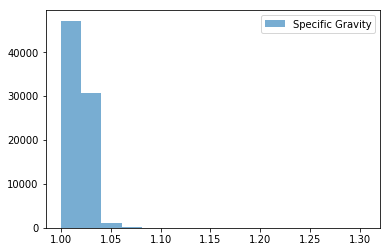

In [162]:
fig, ax = plt.subplots(figsize=(6,4))
ax.hist('ua_spec_grav', data=data,label="Specific Gravity", bins=15, alpha=0.6)
ax.legend()
plt.show()

#### pH has a discrete distribution

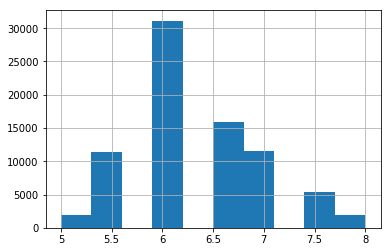

In [133]:
data['ua_ph'].hist()

#### Males with UTI are older than males with no UTI, and older than Females in both outcome categories

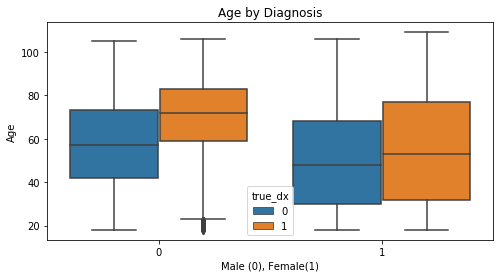

In [139]:
fig, ax = plt.subplots(figsize=(8,4))
sns.boxplot(x='gender_Female',y='age',data=data,hue='true_dx', ax=ax)
ax.set_title('Age by Diagnosis')
ax.set_xlabel('Male (0), Female(1)')
ax.set_ylabel('Age')
plt.show()

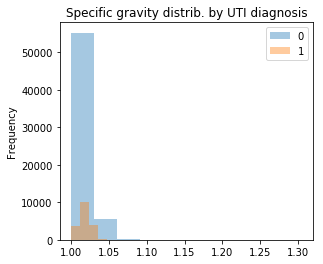

In [150]:
sg_byDx = data.groupby("true_dx")["ua_spec_grav"]
# fig, axes = plt.subplots(2,1,1, figsize=(12, 4))
plt.subplot(1, 2, 1)
sg_byDx.plot(kind='hist', figsize=[10,4], alpha=.4, legend=True, title = "Specific gravity distrib. by UTI diagnosis")
plt.show()

It was easier to see the age effect with the last iteration in which I subsampled the majority to balance the data set.

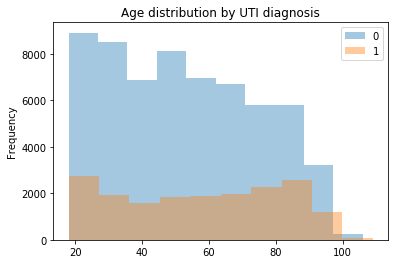

In [151]:
age_byDx = data.groupby("true_dx")["age"]
age_byDx.plot(kind='hist', figsize=[6,4], alpha=.4, legend=True, title = "Age distribution by UTI diagnosis")
plt.show()

In [168]:
data.groupby('true_dx').mean()

,PATID,ua_spec_grav,age,Abdominal_hernia,Abdominal_pain,Acute_and_unspecified_renal_failure,Anal_and_rectal_conditions,Calculus_of_urinary_tract,Cancer,Chronic_renal_failure,...,employStatus_Self Employed,employStatus_Student - Full Time,employStatus_Student - Part Time,employStatus_Unknown,insurance_status_Commercial,insurance_status_Medicaid,insurance_status_Medicare,insurance_status_Other,insurance_status_Self pay,dr_dx
true_dx,,,,,,,,,,,,,,,,,,,,,
0,26288.335749,1.019265,52.647730,0.030868,0.014019,0.010306,0.004646,0.063273,0.085504,0.050317,...,0.026647,0.027629,0.002077,0.001848,0.360368,0.302313,0.261614,0.064729,0.010976,0.154633
1,30172.396986,1.018300,57.625229,0.029860,0.013074,0.015567,0.004598,0.071187,0.109357,0.066866,...,0.022658,0.025206,0.002161,0.001219,0.318154,0.271675,0.352612,0.050524,0.007036,0.414271


### Look at correlations

In [170]:
feat_corr = data.corr() 

In [180]:
indices = np.where(feat_corr > 0.7)
indices = [(feat_corr.index[x], feat_corr.columns[y]) for x, y in zip(*indices)
                                        if x != y and x < y]
        
indices

[('age', 'employStatus_Retired'),
 ('Diabetes_mellitus_without_complication', 'ANTIHYPERGLYCEMICS'),
 ('ua_glucose_not_reported', 'ua_ketones_not_reported'),
 ('ua_glucose_not_reported', 'ua_nitrite_not_reported'),
 ('ua_glucose_not_reported', 'ua_protein_not_reported'),
 ('ua_glucose_other', 'ua_protein_other'),
 ('ua_ketones_not_reported', 'ua_leuk_not_reported'),
 ('ua_ketones_not_reported', 'ua_nitrite_not_reported'),
 ('ua_ketones_not_reported', 'ua_protein_not_reported'),
 ('ua_ketones_other', 'ua_leuk_other'),
 ('ua_ketones_other', 'ua_nitrite_other'),
 ('ua_leuk_not_reported', 'ua_nitrite_not_reported'),
 ('ua_leuk_other', 'ua_nitrite_other'),
 ('ua_nitrite_not_reported', 'ua_protein_not_reported'),
 ('race_Other', 'ethnicity_Hispanic or Latino')]

### Scale the continuous variables

In [178]:
std_scale = preprocessing.StandardScaler().fit(data[['ua_ph', 'ua_spec_grav','age']])
data_std = std_scale.transform(data[['ua_ph', 'ua_spec_grav','age']])

print('Mean after standardization:\npH={:.2f}, Specific Gravity ={:.2f}, Age ={:.2f}'
      .format(data_std[:,0].mean(), data_std[:,1].mean(),data_std[:,2].mean()))
print('\nStandard deviation after standardization:\npH={:.2f}, Specific Gravity ={:.2f}, Age ={:.2f}'
      .format(data_std[:,0].std(), data_std[:,1].std(),data_std[:,2].std()))

Mean after standardization:
pH=0.00, Specific Gravity =0.00, Age =-0.00

Standard deviation after standardization:
pH=1.00, Specific Gravity =1.00, Age =1.00


#### From correlation matrix > 70%, remove not_reported columns, 'other' categories (not informative) and retired employ - corr with age

In [183]:
not_rep_cols = [col for col in data.columns if 'not_reported' in col]
not_rep_cols

['ua_bili_not_reported',
 'ua_clarity_not_reported',
 'ua_color_not_reported',
 'ua_glucose_not_reported',
 'ua_ketones_not_reported',
 'ua_leuk_not_reported',
 'ua_nitrite_not_reported',
 'ua_protein_not_reported',
 'ua_urobili_not_reported',
 'race_not_reported']

In [186]:
other_cols = [col for col in data.columns if 'other' in col]
other_cols.remove('Coronary_atherosclerosis_and_other_heart_disease')
other_cols.remove('Delirium__dementia__and_amnestic_and_other_cognitive_disorders')
other_cols.remove('Maintenance_chemotherapy__radiotherapy')
other_cols

['ua_bili_other',
 'ua_blood_other',
 'ua_color_other',
 'ua_glucose_other',
 'ua_ketones_other',
 'ua_leuk_other',
 'ua_nitrite_other',
 'ua_protein_other',
 'chief_complaint_other']

In [187]:
drop_oth_not_rep_cols = [other_cols,not_rep_cols]
for var in drop_oth_not_rep_cols:
    data.drop(var, axis=1,inplace=True) 

In [189]:
data.drop('employStatus_Retired', axis=1, inplace=True)

### Ready for cross-validation and model fit

In [253]:
df = data.copy()
df.head()

,PATID,ua_ph,ua_spec_grav,age,abx,Abdominal_hernia,Abdominal_pain,Acute_and_unspecified_renal_failure,Anal_and_rectal_conditions,Calculus_of_urinary_tract,...,employStatus_Student - Full Time,employStatus_Student - Part Time,employStatus_Unknown,insurance_status_Commercial,insurance_status_Medicaid,insurance_status_Medicare,insurance_status_Other,insurance_status_Self pay,dr_dx,true_dx
0,1,7.5,1.020,83,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
1,1,6.0,1.017,81,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,2,5.0,1.016,78,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,3,5.5,1.016,84,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
4,4,6.0,1.030,55,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


standardize variables in place to compare with sklearn standardization in 'data' vs 'df' standardized manually

In [254]:
cols = ['age', 'ua_ph','ua_spec_grav']
for col in cols:
    df_zscore = (df[col] - df[col].mean())/df[col].std()
    df[col] = df_zscore
df.head()

,PATID,ua_ph,ua_spec_grav,age,abx,Abdominal_hernia,Abdominal_pain,Acute_and_unspecified_renal_failure,Anal_and_rectal_conditions,Calculus_of_urinary_tract,...,employStatus_Student - Full Time,employStatus_Student - Part Time,employStatus_Unknown,insurance_status_Commercial,insurance_status_Medicaid,insurance_status_Medicare,insurance_status_Other,insurance_status_Self pay,dr_dx,true_dx
0,1,1.873916,0.105358,1.302669,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
1,1,-0.457167,-0.223958,1.213406,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
2,2,-2.011222,-0.333730,1.079511,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,1
3,3,-1.234194,-0.333730,1.347301,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,1
4,4,-0.457167,1.203078,0.052984,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [222]:
df.ua_ph.value_counts()

-0.457167    31121
 0.319861    15920
-1.234194    11430
 1.096888    10886
 1.873916     5384
 2.650943     1895
-2.011222     1895
Name: ua_ph, dtype: int64

In [223]:
data.ua_ph.mean()

6.294176821891992

In [224]:
drdx_v_true = pd.crosstab(data["true_dx"], data["dr_dx"])
drdx_v_true

dr_dx,0,1
true_dx,,
0,51275,9391
1,10468,7397


#### Make the first train-test split 

In [258]:
X = data.iloc[:, 1:191].values  # this skips dr_dx(col 192) and patID(col 0)
y = data.iloc[:, 192].values  # target, true_dx
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 11)

#### Make a second split in the training set to allow for a separate validation set prior to final testing on the hold-out test set.

In [259]:
X_train_rfe, X_val_rfe, y_train_rfe, y_val_rfe = train_test_split(X_train, y_train, test_size = 0.20, random_state = 1)

#### Create the Recursive Feature Elimination object and compute a cross-validated score.
##### Establish base parameters for non-penalized Logistic Regression with balanced classes (vs sub-sampling majority)

In [397]:
logreg = LogisticRegression(C=10**6,class_weight='balanced')

Optimal number of features : 184


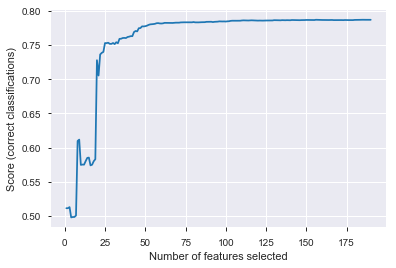

In [398]:
# The "accuracy" scoring is proportional to the number of correct classifications
rfecv = RFECV(estimator=logreg, step=1, cv=StratifiedKFold(3),
              scoring='accuracy')
rfecv.fit(X_train, y_train)

print("Optimal number of features : %d" % rfecv.n_features_)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Score (correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [251]:
profile = ProfileReport(data)
profile.to_file(outputfile="yootassess_profile.html")

#### Run RFE with 30 features; i+1 for column fetch due to patID kept in df but not included in training set

In [285]:
def rfe_logistic(classifier,n,X_train,y_train,df):
    rfe_cols = []
    rfe = RFE(classifier,n)
    rfe = rfe.fit(X_train, y_train)
    rfe_rank = rfe.ranking_
    rfe_score = rfe.score(X_train_rfe, y_train_rfe)
    
    for i,val in enumerate(rfe_rank):
        if val == True:
            rfe_cols.append(df.columns[i+1])
    
    return(rfe_rank, rfe_score,rfe_cols)

In [286]:
rfe_logistic(logreg,30,X_train_rfe,y_train_rfe,data)

(array([ 91,   1, 157,  10, 135,  49,  59, 124,  56, 117, 140, 146, 143,
        126, 153, 114, 151,  83,  55, 120,  53, 122,  22, 100,  63,  20,
        158,  35, 154, 115, 137,  39,  52,  73,   1,   1,   1, 103, 138,
         50,  38, 116,  94,   1,  61, 107, 113, 127,   1, 150, 106,  69,
         47,  36,  68,  62,  51,  43, 125, 109, 149,  72,  89, 123,  58,
         15,  11, 139, 147, 159,  71, 148,  64,  75,  93, 156, 155, 142,
        129, 108,  57,   1,  74, 112, 102, 105, 136, 101,  37, 141,  70,
         78,  54,   1,   1,   7, 131,  42,  12, 121,  29,   1,  66, 118,
          8,   1,   1,  26,   1,   1,   1,   1,   1, 160,  28,  76,  77,
          1,  27,   1,   1,   1, 145,  32,  33,   4,  31,   1,   1, 134,
        119,  82,  65,  81,  14,  46,  80,  92,  40,   3,  13,  79, 130,
        161,   1,  34,   1, 133,  48,   1,   1,   6,  21,  86, 152,  67,
         84,  41,   2,  85,  87,  90,   1,   9, 110, 111,   1,  98,  25,
         44,  97,  30,  99,  95,   1,  96,  45,  17

In [287]:
rfe20 = rfe_logistic(logreg,20,X_train_rfe,y_train_rfe,data)
rfe20

(array([101,   1, 167,  20, 145,  59,  69, 134,  66, 127, 150, 156, 153,
        136, 163, 124, 161,  93,  65, 130,  63, 132,  32, 110,  73,  30,
        168,  45, 164, 125, 147,  49,  62,  83,   1,  10,   1, 113, 148,
         60,  48, 126, 104,   7,  71, 117, 123, 137,   1, 160, 116,  79,
         57,  46,  78,  72,  61,  53, 135, 119, 159,  82,  99, 133,  68,
         25,  21, 149, 157, 169,  81, 158,  74,  85, 103, 166, 165, 152,
        139, 118,  67,   3,  84, 122, 112, 115, 146, 111,  47, 151,  80,
         88,  64,   1,   1,  17, 141,  52,  22, 131,  39,   1,  76, 128,
         18,   1,   2,  36,   1,   1,   1,   1,   1, 170,  38,  86,  87,
          1,  37,   1,   4,   1, 155,  42,  43,  14,  41,   1,   1, 144,
        129,  92,  75,  91,  24,  56,  90, 102,  50,  13,  23,  89, 140,
        171,   6,  44,   9, 143,  58,   1,   1,  16,  31,  96, 162,  77,
         94,  51,  12,  95,  97, 100,  11,  19, 120, 121,   5, 108,  35,
         54, 107,  40, 109, 105,   8, 106,  55,  27

#### Compare with Logistic Regression with L1 penalty weights (LASSO) - peform GridSearch for hyperparameter tuning
The scoring set here is for R2, which gives the proportion of variability with reduced features.

(0.001, 0.31622776601683794)

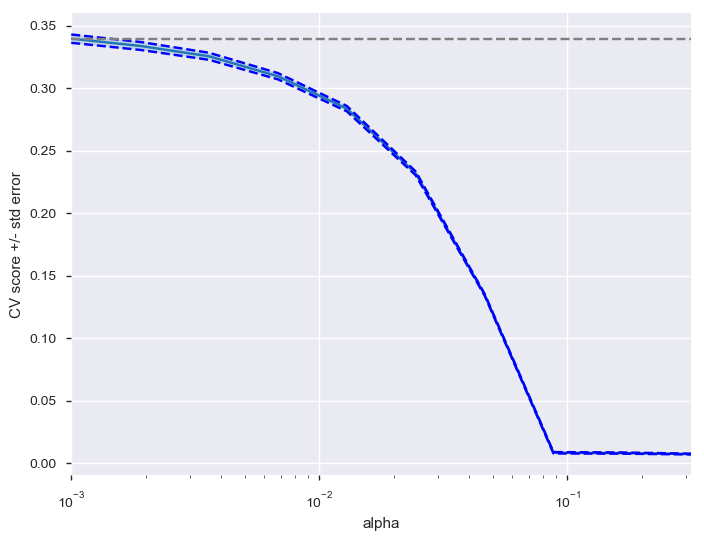

In [269]:
lasso = Lasso(random_state=123, max_iter=1e5)
alphas = np.logspace(-3, -0.5, 10)

tuned_parameters = [{'alpha': alphas}]
n_folds = 3

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False, return_train_score=True)
clf.fit(X_train, y_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

#### Run LASSO with different alphas;i+1 for column fetch due to patID kept in df but not included in training set

In [383]:
def lasso_logistic(c,X_train,y_train,df):
    classifier = LogisticRegression(random_state=123, penalty='l1', solver='liblinear', C=c, class_weight='balanced')
    classifier.fit(X_train,y_train)

    logl1_coef = classifier.coef_
    logl1_intercept = classifier.intercept_

    logl1_coef_nonzeros = np.nonzero(logl1_coef)[1]
    
    # save the list of nonzero coefficient values:
    coef = np.nonzero(classifier.coef_)[1]
    logl1_coef_values = []
    for i in coef:
        logl1_coef_values.append(classifier.coef_[0][i])
        
    # save the list of coefficient feature names:
    logl1_coef_list =[]
    for i in logl1_coef_nonzeros:
        logl1_coef_list.append(df.columns[i+1])
        
    return(logl1_intercept, logl1_coef_list, logl1_coef_values)

In [384]:
L_001 = lasso_logistic(0.001,X_train_rfe,y_train_rfe,data)
L_001

(array([ 0.]),
 ['age',
  'abx',
  'ua_blood_negative',
  'ua_clarity_clear',
  'ua_leuk_large',
  'ua_leuk_negative',
  'ua_nitrite_positive',
  'gender_Female'],
 [0.0076916993515540252,
  0.20541721165795418,
  -0.094399430639239293,
  -0.50000822345329266,
  0.067968828835357611,
  -1.3805702047268364,
  0.88023888146693952,
  0.14221692731063185])

In [385]:
L_005 = lasso_logistic(0.005,X_train_rfe,y_train_rfe,data)
L_005

(array([ 0.]),
 ['ua_ph',
  'age',
  'abx',
  'Diabetes_mellitus_without_complication',
  'Urinary_tract_infections',
  'ANTIHYPERGLYCEMICS',
  'ua_bili_negative',
  'ua_blood_moderate',
  'ua_blood_negative',
  'ua_clarity_clear',
  'ua_color_red',
  'ua_color_yellow',
  'ua_leuk_large',
  'ua_leuk_moderate',
  'ua_leuk_negative',
  'ua_leuk_small',
  'ua_nitrite_negative',
  'ua_nitrite_positive',
  'ua_protein_negative',
  'ua_urobili_negative',
  'gender_Male'],
 [0.017399578581079128,
  0.0080279507975335399,
  0.35969378239196342,
  0.020804556188574814,
  0.18542672554717043,
  0.075047489012720958,
  0.38095272785883905,
  0.0076362626938192768,
  -0.24843380694786041,
  -0.58328914906867835,
  -0.034013881119190542,
  0.13382377686508884,
  0.55664401306926747,
  0.00048891041379196267,
  -1.68588105287289,
  -0.33616418200226655,
  -0.49757772983370224,
  1.1128467912263547,
  -0.14356941598564865,
  0.44118444996947537,
  -0.61763455233969866])

In [284]:
L_005_df = lasso_logistic(0.005,X_train_rfe,y_train_rfe,df)
L_005_df

(array([ 0.]),
 ['ua_ph',
  'age',
  'abx',
  'Diabetes_mellitus_without_complication',
  'Urinary_tract_infections',
  'ANTIHYPERGLYCEMICS',
  'ua_bili_negative',
  'ua_blood_moderate',
  'ua_blood_negative',
  'ua_clarity_clear',
  'ua_color_red',
  'ua_color_yellow',
  'ua_leuk_large',
  'ua_leuk_moderate',
  'ua_leuk_negative',
  'ua_leuk_small',
  'ua_nitrite_negative',
  'ua_nitrite_positive',
  'ua_protein_negative',
  'ua_urobili_negative',
  'gender_Male'])

So, no difference between manually standardizing continuous variables and doing pre-processing with sklearn standard scalar

#### Prepare a reduced feature data set for validation testing

In [288]:
train_cols = data.columns[1:(len(data.columns)-2)] #to remove dr_dx, true_dx, the last 2 columns in set
X_train_rfe_df = pd.DataFrame(X_train_rfe)
X_train_rfe_df.columns = train_cols
X_train_rfe_df.head()

,ua_ph,ua_spec_grav,age,abx,Abdominal_hernia,Abdominal_pain,Acute_and_unspecified_renal_failure,Anal_and_rectal_conditions,Calculus_of_urinary_tract,Cancer,...,employStatus_Part Time,employStatus_Self Employed,employStatus_Student - Full Time,employStatus_Student - Part Time,employStatus_Unknown,insurance_status_Commercial,insurance_status_Medicaid,insurance_status_Medicare,insurance_status_Other,insurance_status_Self pay
0,6.5,1.010,56.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,7.0,1.018,24.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,6.5,1.016,54.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,7.0,1.023,40.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,7.0,1.017,70.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [289]:
l1_cols = ['ua_ph','age','abx','Diabetes_mellitus_without_complication','Urinary_tract_infections',
           'ua_bili_negative','ua_blood_moderate','ua_blood_negative','ua_clarity_clear','ua_color_red',
           'ua_color_yellow','ua_leuk_large','ua_leuk_negative','ua_nitrite_negative','ua_nitrite_positive',
           'ua_protein_negative','ua_urobili_negative','gender_Male']

X_l1 = X_train_rfe_df[l1_cols] # new X with reduced features
y_l1 = y_train_rfe.ravel()

#### compare coeficients and p-values to logistic model without regularization parameters built in

In [290]:
import statsmodels.api as sm
logit_model=sm.Logit(y_l1,X_l1.astype(float))
result=logit_model.fit()
print(result.summary())

C:\ProgramData\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Optimization terminated successfully.
         Current function value: 0.369297
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                50259
Model:                          Logit   Df Residuals:                    50241
Method:                           MLE   Df Model:                           17
Date:                Tue, 24 Jul 2018   Pseudo R-squ.:                  0.3114
Time:                        17:16:11   Log-Likelihood:                -18561.
converged:                       True   LL-Null:                       -26955.
                                        LLR p-value:                     0.000
                                             coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------
ua_ph                                      0.0506   

In [292]:
kfold = model_selection.KFold(n_splits=10, random_state=7)
modelCV = LogisticRegression(random_state=123, penalty='l1', solver='liblinear', C=0.005)
scoring = 'accuracy'
results = model_selection.cross_val_score(modelCV, X_l1, y_l1, cv=kfold, scoring=scoring)
print("10-fold cross validation average accuracy: %.3f" % (results.mean()))

10-fold cross validation average accuracy: 0.832


#### Prepare the validation set for testing

In [293]:
X_val_rfe_df = pd.DataFrame(X_val_rfe)
X_val_rfe_df.columns = train_cols  # apply from previous prep on training set

y_val_test = y_val_rfe.ravel()
X_val_test_l1 = X_val_rfe_df[l1_cols]
X_val_test_l1.shape

(12565, 18)

#### fit the LASSO model with reduced features

In [396]:
def validate_lasso(c, X_fit,y_fit,X_test,y_test):
    classifier = LogisticRegression(random_state=123, penalty='l1', solver='liblinear', C=c, class_weight='balanced')
    classifier.fit(X_fit, y_fit)
    y_pred = classifier.predict(X_test)
    y_pred_proba = classifier.predict_proba(X_test)[:,1]
    cm = confusion_matrix(y_test, y_pred)
    return(cm, y_pred,y_pred_proba, 'Accuracy of logistic regression classifier on test set: {:.2f}'.format(classifier.score(X_test, y_test)))

In [338]:
l1_val = validate_lasso(0.005, X_l1,y_l1,X_val_test_l1,y_val_test)
l1_val

(array([[7354, 2354],
        [ 583, 2274]], dtype=int64),
 array([0, 0, 1, ..., 1, 1, 1]),
 array([ 0.15864816,  0.3222614 ,  0.67587893, ...,  0.5334423 ,
         0.89311856,  0.97853828]),
 'Accuracy of logistic regression classifier on test set: 0.77')

In [321]:
l1_val[0]

array([[7354, 2354],
       [ 583, 2274]], dtype=int64)

In [395]:
print(classification_report(y_val_test, l1_val[1]))  # y_pred is the 2nd element in the function return

             precision    recall  f1-score   support

          0       0.93      0.76      0.83      9708
          1       0.49      0.80      0.61      2857

avg / total       0.83      0.77      0.78     12565



In [312]:
def  plot_confusion_matrix (cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


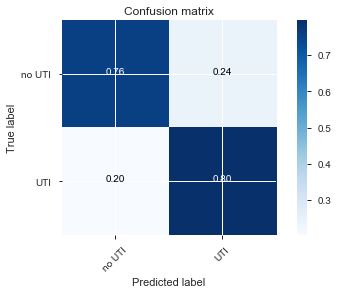

In [327]:
plot_confusion_matrix(l1_val[0],['no UTI','UTI'], normalize = True)

### Run the validation/test model plus confusion matrix and ROC: Thanks to Eric Harness...

In [308]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, roc_auc_score, roc_curve

def cm_roc_combo(conf_matrix, labels, y_test, y_pred, y_pred_proba):
    plt.figure(figsize=(16, 4))
    # confusion matrix
    predicted_labels = ['Predicted ' + label for label in labels]
    actual_labels = ['Actual ' + label for label in labels]
    df_cm = pd.DataFrame(conf_matrix, index = actual_labels, columns = predicted_labels)
    plt.subplot(1, 2, 1)
    sns.heatmap(df_cm, annot=True)
    # ROC curve
    roc_auc = roc_auc_score(y_test, y_pred)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label = 'AUC = {:0.2f}'.format(roc_auc,2))
    plt.plot([0, 1], [0, 1],'r--')
    plt.legend(loc = 'lower right')
    LIMS = [-0.01,1.01] 
    plt.xlim(LIMS)
    plt.ylim(LIMS)
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.show()
    
def scores_one_liner(name, y_test, y_pred):
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    score_string = 'Scores for {}: Accuracy={:0.2f}, Precision={:0.2f}, Recall={:0.2f}, F1={:0.2f}'.format(name, acc, prec, rec, f1)
    return score_string

In [309]:
def run_models(models, names, X_train, X_test, y_train, y_test):
    for i, model in enumerate(models):
        model_name = names[i]
        print('---------------')
        print(model_name.upper())
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)
        conf_matrix = confusion_matrix(y_test, y_pred)
        cm_roc_combo(conf_matrix, LABELS, y_test, y_pred, y_pred_proba[:,1])
        print(scores_one_liner(model_name, y_test, y_pred))

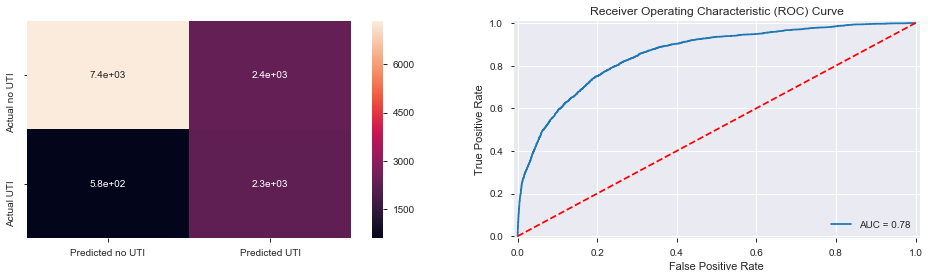

In [340]:
# l1_val = validate_lasso(0.005, X_l1,y_l1,X_val_test_l1,y_val_test)
cm_roc_combo(l1_val[0],['no UTI','UTI'], y_val_test, l1_val[1], l1_val[2])

Run the L1 Model on the Hold-out test set, using the same training column names as before

In [341]:
X_final_test_df = pd.DataFrame(X_test)
X_final_test_df.columns = train_cols
y_final_test = y_test.ravel()
X_final_test = X_final_test_df[l1_cols]
X_final_test.shape

(15707, 18)

In [342]:
l1_final = validate_lasso(0.005, X_l1,y_l1,X_final_test,y_final_test)
l1_final

(array([[9172, 2964],
        [ 777, 2794]], dtype=int64),
 array([0, 0, 0, ..., 1, 1, 0]),
 array([ 0.15176044,  0.16267127,  0.19335964, ...,  0.9041018 ,
         0.77626342,  0.28150234]),
 'Accuracy of logistic regression classifier on test set: 0.76')

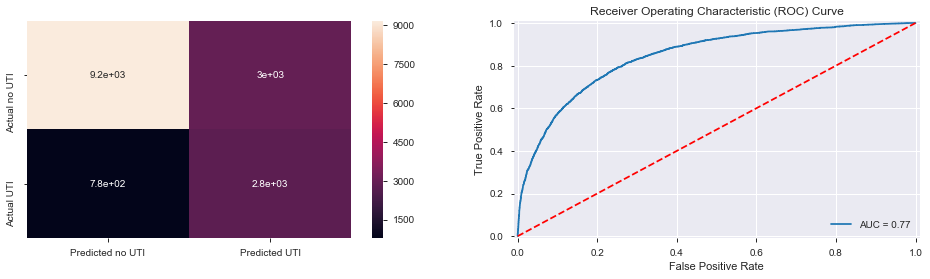

In [343]:
cm_roc_combo(l1_final[0],['no UTI','UTI'], y_final_test, l1_final[1], l1_final[2])

normalized confusion matrix for the final hold-out test set

Normalized confusion matrix


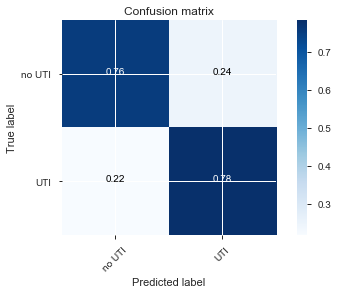

In [344]:
plot_confusion_matrix(l1_final[0],['no UTI','UTI'], normalize = True)

In [345]:
print(classification_report(y_final_test, l1_final[1]))

             precision    recall  f1-score   support

          0       0.92      0.76      0.83     12136
          1       0.49      0.78      0.60      3571

avg / total       0.82      0.76      0.78     15707



#### And finally, we see the feature importances

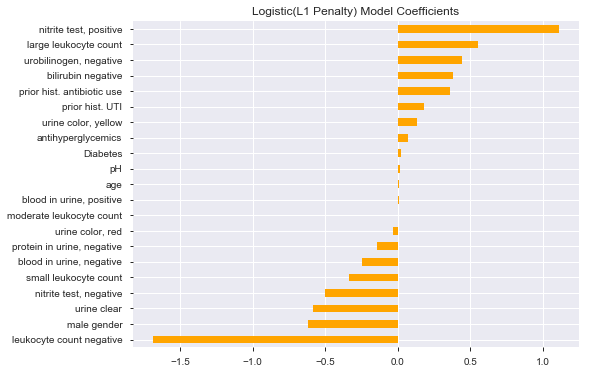

In [387]:
from pandas import Series, DataFrame

comm_names = ['pH','age','prior hist. antibiotic use','Diabetes','prior hist. UTI','antihyperglycemics',
              'bilirubin negative', 'blood in urine, positive','blood in urine, negative', 'urine clear', 
              'urine color, red','urine color, yellow','large leukocyte count','moderate leukocyte count',
              'leukocyte count negative','small leukocyte count', 'nitrite test, negative', 'nitrite test, positive',
              'protein in urine, negative','urobilinogen, negative','male gender']
plt.figure(figsize=(8,6))
plt.tight_layout()
predictors_final = comm_names
predictors_final = Series(L_005[2],predictors_final).sort_values()
predictors_final.plot(kind='barh', title= 'Logistic(L1 Penalty) Model Coefficients', color='orange')
plt.show()

There is still work here to be done. The features make a bit more sense but there are still interactions to be cleaned up. Applying the sklearn balanced class parameter instead of downsampling the majority class resulted in large decrease in precision, although the sensitivity increased from the subsampled model.